# Assignment 2 : Seaquest environment



This notebook demonstrates how to solve the Seaquest problem using two state-of-the-art reinforcement learning algorithms: Deep Q-Network (DQN) and Proximal Policy Optimization (PPO). We'll implement, train, and evaluate these algorithms to maximize the agent's score in the Seaquest environment.

## Project Structure:

1. **Problem Formulation**
   - Seaquest environment explanation
   - State and action spaces
   - Reward structure and termination conditions

2. **Method Implementation**
   - Deep Q-Network (DQN) implementation
   - Proximal Policy Optimization (PPO) implementation
   - Key hyperparameters and architectural choices

3. **Training and Simulation**
   - Agent training procedures
   - Visualization of agent behavior
   - Comparison of learning progress

4. **Performance Evaluation**
   - Learning curve analysis
   - Comparative performance metrics
   - Strengths and weaknesses of each approach

## Setup and Dependencies Installation

Let's begin by installing the required libraries for our Seaquest experiments.

# 1. Problem Formulation

## The Seaquest Problem

Seaquest is a classic Atari 2600 game where the player controls a submarine navigating underwater environments. The objective is to rescue divers while avoiding or destroying enemy submarines and sea creatures. This presents a complex reinforcement learning challenge that combines strategic planning, spatial navigation, and resource management.

### Game Mechanics:
- **Submarine Control**: The player controls a submarine that can move in four directions and fire torpedoes
- **Diver Rescue**: Divers appear throughout the level and must be rescued by touching them
- **Enemy Combat**: Various sea creatures and enemy submarines pose threats that can be destroyed for points
- **Oxygen Management**: The submarine has limited oxygen and must surface periodically to refill
- **Lives System**: The player has multiple lives, losing one when hit by enemies or running out of oxygen

## Environment Details:
- **State Space**: High-dimensional pixel observations (210×160×3 RGB images) representing the game screen
- **Action Space**: Discrete with 18 possible actions (combinations of movement directions, firing, and no-op)
- **Reward Structure**:
  - +50 points for rescuing a diver
  - +20-90 points for destroying different types of enemies
  - Bonus points for completing levels
  - Negative reward when losing a life
- **Episode Termination**: Game ends when all lives are lost or maximum timesteps reached

## Library Imports and Environment Setup

We'll import the necessary Python libraries and set up our Seaquest environment.

In [ ]:
# @title
# Installing the Box2D environment for physics simulation
!pip install gymnasium
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2409499 sha256=51f33dfaee20f9bc0252c8ff8b7a19da1682202244b0bb45eb62666eaa5f79cf
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [ ]:
# Updating the package list and installing necessary packages for the project
!sudo apt-get install cmake
# Updating the package list and installing ffmpeg and freeglut3-dev for visualization, xvfb for virtual display
!sudo apt-get install -y ffmpeg freeglut3-dev xvfb

# Installing the Stable Baselines3 library for reinforcement learning along with extra dependencies
!pip install "stable-baselines3[extra]>=2.0.0a4"

!pip install ale-py

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.15).
The following additional packages will be installed:
  freeglut3 libegl-dev libgl-dev libgl1-mesa-dev libgles-dev libgles1
  libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev libglx-dev
  libopengl-dev libxt-dev
Suggested packages:
  libxt-doc
The following NEW packages will be installed:
  freeglut3 freeglut3-dev libegl-dev libgl-dev libgl1-mesa-dev libgles-dev
  libgles1 libglu1-mesa libglu1-mesa-dev libglvnd-core-dev libglvnd-dev
  libglx-dev libopengl-dev libxt-dev
0 upgraded, 14 newly installed, 0 to remove and 38 not upgrade

# 2. Method Implementation

In this project, we implement two state-of-the-art reinforcement learning algorithms to solve the Seaquest problem:

## Deep Q-Network (DQN)

DQN is a value-based reinforcement learning algorithm that uses a neural network to approximate the Q-function, which estimates the expected cumulative reward for taking actions in states.

## Proximal Policy Optimization (PPO)

PPO is a policy gradient method that directly optimizes the policy function. It uses a "trust region" approach to ensure stable updates by limiting how much the policy can change in each iteration.

Key features of our PPO implementation:
- **Neural Network Architecture**: Separate policy and value networks
- **Advantage Estimation**: Generalized Advantage Estimation (GAE) with λ=0.95
- **Policy Updates**: Multiple epochs of minibatch updates with clipped objective
- **Entropy Bonus**: Small entropy term to encourage exploration

We'll train both algorithms on the Seaquest environment and compare their performance.

In [27]:
# Importing required libraries and modules
import os
import gymnasium as gym  # Importing gym library as gymnasium

# Printing the version of gym library
print(f"{gym.__version__=}")
import base64
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import stable_baselines3

# Printing the version of stable_baselines3 library
print(f"{stable_baselines3.__version__=}")
from stable_baselines3 import DQN
from IPython import display as ipythondisplay
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch
import torch.nn as nn
import base64
from IPython import display as ipythondisplay


# Setting up a fake display for video rendering
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

# Import utility functions for creating Atari environments and stacking frames
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack


gym.__version__='1.2.1'
stable_baselines3.__version__='2.7.0'


sh: 1: Xvfb: not found


## Define a callback to store model on interval (for checkpointing)

In [28]:
# Defining a callback class to save the model at specified intervals
class SaveOnIntervalCallback(BaseCallback):
    def __init__(self, save_interval: int, save_path: str, verbose=1):
        super().__init__(verbose)
        self.save_interval = save_interval  # Setting the interval of saving
        self.save_path = save_path  # Setting the path to save models

    def _on_step(self) -> bool:
        # Saving the model if the current timestep is a multiple of the save interval
        if self.num_timesteps % self.save_interval == 0:
            save_file = os.path.join(self.save_path, f'model_{self.num_timesteps}')  # Defining the file name for the model
            self.model.save(save_file)  # Saving the model
            if self.verbose > 0:
                print(f'Saving model to {save_file}.zip')  # Printing a message on successful save
        return True


## Create directories for storage of model and logs

In [29]:
# Creating directories for storing logs and models
log_dir_dqn = "week9/train2/gym/dqn/"  # Directory for storing DQN training logs
log_dir_ppo = "week9/train2/gym/ppo/"  # Directory for storing PPO training logs
models_dir_dqn = "week9/train2/models/dqn/"  # Directory for storing DQN models
models_dir_ppo = "week9/train2/models/ppo/"  # Directory for storing PPO models
video_path = "week9/train2/videos/"

# Ensuring the directories exist or creating them
os.makedirs(log_dir_dqn, exist_ok=True)
os.makedirs(log_dir_ppo, exist_ok=True)
os.makedirs(models_dir_dqn, exist_ok=True)
os.makedirs(models_dir_ppo, exist_ok=True)
os.makedirs(video_path, exist_ok=True)


## Seaquest Environment Initialization

Creating our Seaquest environment instance using Gymnasium.

In [30]:
# Creating and wrapping the environment with a monitor for logging
import ale_py  # Importing the ALE (Arcade Learning Environment) package
from stable_baselines3.common.vec_env import VecFrameStack, VecMonitor
from stable_baselines3.common.monitor import Monitor

# Initialize the Atari environment with the specified game and configurations
env = make_atari_env("SeaquestNoFrameskip-v4", n_envs=8, seed=0)
# Stack 4 consecutive frames together to provide temporal information
# Add monitoring (one CSV per parallel environment)
env = VecMonitor(env, filename=os.path.join(log_dir_dqn, "monitor.csv"))
env = VecFrameStack(env, n_stack=4)



## Utility Functions

### Record Video

In [31]:
def record_video(env_id, model, video_length=500, prefix="", video_folder="week9/train2/videos/"):
    eval_env = make_atari_env(env_id, n_envs=1, seed=0, vec_env_cls=DummyVecEnv)  # Create a single Atari environment
    eval_env = VecFrameStack(eval_env, n_stack=4)  # Stack 4 frames together for temporal information
    eval_env = VecVideoRecorder(  # Initialize video recorder
        eval_env,
        video_folder=video_folder,  # Specify folder to save videos
        record_video_trigger=lambda step: step == 0,  # Set trigger to start recording at step 0
        video_length=video_length,  # Set video length
        name_prefix=prefix,  # Set prefix for video filenames
    )
    obs = eval_env.reset()  # Reset the environment to get initial observation
    for _ in range(video_length):  # Loop through for the specified video length
        action, _ = model.predict(obs)  # Predict action based on current observation
        obs, _, _, _ = eval_env.step(action)  # Execute action in the environment
    eval_env.close()  # Close the environment and video recorder

### Show Video

In [32]:
# Functions to record videos of the agent playing and display the videos

def show_videos(video_path="week9/train2/videos/", prefix=""):
    """Displays videos from a specified directory."""
    html = []
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            '''<video alt="{0}" autoplay
                      loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{1}" type="video/mp4" />
            </video>'''.format(mp4, video_b64.decode('ascii'))
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))


## DQN Training for Seaquest

Training a Deep Q-Network agent on the Seaquest balancing task.

# 3. Training and Simulation

### Initialise the callback

In [33]:
# Instantiating and training the DQN agent with callback for saving
save_interval = 2000000 // 3  # Setting save interval to save three models: at the beginning, middle, and end of training
callback = SaveOnIntervalCallback(save_interval, save_path=models_dir_dqn)  # Initializing the callback


### Initialise the DQN Model with the following hyper-parameters:

In [34]:
# Define a custom CNN feature extractor for processing observations from the environment
class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 512):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # Define the convolutional layers
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_space.shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute the size of the output tensor after passing through the CNN
        with torch.no_grad():
            n_flatten = self.cnn(
                torch.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        # Define the linear layers that follow the convolutional layers
        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        # Process the observations through the CNN and linear layers
        return self.linear(self.cnn(observations))


In [35]:
# Initialize the DQN agent with specified parameters
model = DQN(
    env=env,
    policy='CnnPolicy',
    verbose=1,
    learning_rate=0.0001,
    buffer_size=10000,
    learning_starts=0,
    gradient_steps=1,
    exploration_fraction=0.1,
    exploration_final_eps=0.01,
    train_freq=40,
    batch_size=128,
    ######-----------ADD CUSTOM CNN TO SB3----------------------########
    # Uncomment the next line to use the custom CNN feature extractor
    policy_kwargs={'features_extractor_class': CustomCNN}
    ######------------------------------------------------------########
)


Using cuda device
Wrapping the env in a VecTransposeImage.


In [36]:
model.learn(total_timesteps=2000000, callback=callback)  # Training the agent

# Saving the final model
model.save(os.path.join(models_dir_dqn, "model_final"))  # Saving the final model


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 67.8     |
|    ep_rew_mean      | 0        |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 339      |
|    time_elapsed     | 2        |
|    total_timesteps  | 720      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0156   |
|    n_updates        | 2        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 88.9     |
|    ep_rew_mean      | 0.375    |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 497      |
|    time_elapsed     | 2        |
|    total_timesteps  | 1480     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0156   |
|    n_updates      

### Record and Store Videos

In [37]:
# Functions for analyzing the trained models

# Function to get the identifiers of saved models
def get_model_identifiers(models_dir):
    files = os.listdir(models_dir)  # Listing files in the models directory
    model_files = [f for f in files if f.startswith('model_')]  # Filtering out model files
    identifiers = [f.split('_')[1] for f in model_files]  # Extracting identifiers from file names
    return identifiers

# Function to find key identifiers (earliest, middle, final)
def find_key_identifiers(identifiers):
    identifiers.sort()  # Sorting identifiers
    earliest = identifiers[0]  # Earliest identifier
    final = identifiers[-1]  # Final identifier
    middle = identifiers[len(identifiers) // 2]  # Middle identifier
    return earliest, middle, final

# Function to view videos of the models at different training stages
def view_dqn():
    identifiers = get_model_identifiers(models_dir_dqn)  # Getting model identifiers
    earliest, middle, final = find_key_identifiers(identifiers)  # Finding key identifiers

    # Recording and displaying videos at the beginning, middle, and end of training
    for stage, identifier in zip(["beginning", "middle", "end"], [earliest, middle, final]):
        model_path = os.path.join(models_dir_dqn, f'model_{identifier}')  # Forming the model path
        model = DQN.load(model_path)  # Loading the model
        record_video("SeaquestNoFrameskip-v4", model, video_length=500, prefix=f'dqn-seaquest-{stage}')  # Recording video
        show_videos("week9/train2/videos/", prefix=f'dqn-seaquest-{stage}')  # Showing videos

### Call function to record and store videos

In [38]:
!pip install 'gymnasium[other]'

In [39]:
view_dqn()  # Calling the view function for DQN

Saving video to /home/sagemaker-user/week9/train2/videos/dqn-seaquest-beginning-step-0-to-step-500.mp4
MoviePy - Building video /home/sagemaker-user/week9/train2/videos/dqn-seaquest-beginning-step-0-to-step-500.mp4.
MoviePy - Writing video /home/sagemaker-user/week9/train2/videos/dqn-seaquest-beginning-step-0-to-step-500.mp4



MoviePy - Done !
MoviePy - video ready /home/sagemaker-user/week9/train2/videos/dqn-seaquest-beginning-step-0-to-step-500.mp4


Saving video to /home/sagemaker-user/week9/train2/videos/dqn-seaquest-middle-step-0-to-step-500.mp4
MoviePy - Building video /home/sagemaker-user/week9/train2/videos/dqn-seaquest-middle-step-0-to-step-500.mp4.
MoviePy - Writing video /home/sagemaker-user/week9/train2/videos/dqn-seaquest-middle-step-0-to-step-500.mp4



MoviePy - Done !
MoviePy - video ready /home/sagemaker-user/week9/train2/videos/dqn-seaquest-middle-step-0-to-step-500.mp4


Saving video to /home/sagemaker-user/week9/train2/videos/dqn-seaquest-end-step-0-to-step-500.mp4
MoviePy - Building video /home/sagemaker-user/week9/train2/videos/dqn-seaquest-end-step-0-to-step-500.mp4.
MoviePy - Writing video /home/sagemaker-user/week9/train2/videos/dqn-seaquest-end-step-0-to-step-500.mp4



MoviePy - Done !
MoviePy - video ready /home/sagemaker-user/week9/train2/videos/dqn-seaquest-end-step-0-to-step-500.mp4


## DQN Performance on Seaquest

Visualizing the learning progress of our DQN agent on the Seaquest task.

# 4. Performance Evaluation

In this section, we'll analyze and compare the performance of our DQN and PPO agents on the Seaquest task. We'll examine various metrics and visualizations to understand the strengths and weaknesses of each approach.

## Evaluation Metrics

We'll assess performance based on several key metrics:

1. **Learning Efficiency**: How quickly does each algorithm learn to balance the pole?
2. **Final Performance**: What is the maximum average reward achieved?
3. **Stability**: How consistent are the results across training runs and episodes?
4. **Sample Efficiency**: How many environment interactions are needed to reach good performance?

Through these comparisons, we aim to identify which algorithm is better suited for the Seaquest task, and under what circumstances each might be preferred.

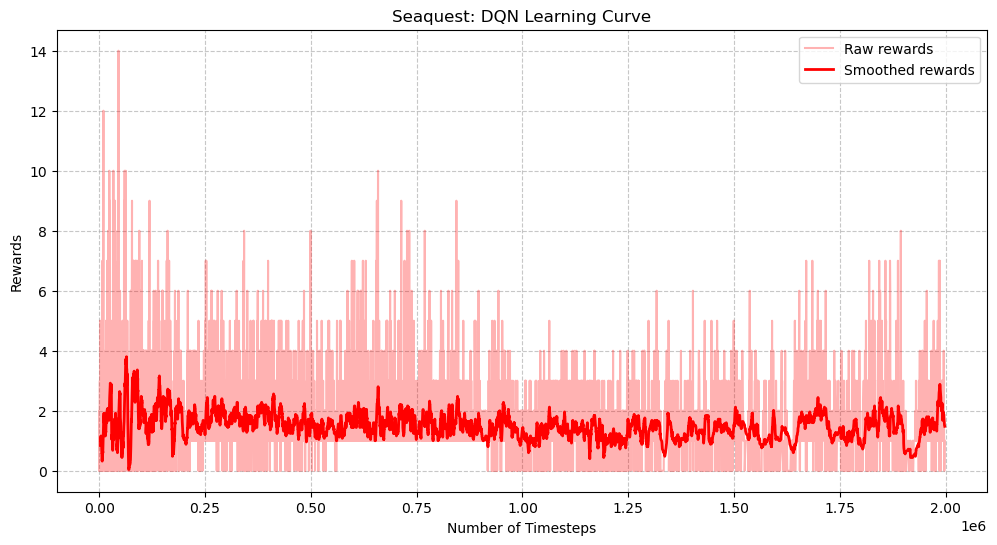

In [40]:
# Plot DQN learning curve for Seaquest
def plot_dqn_results(log_folder, title="DQN Learning Curve"):
    try:
        # Loading the results with error handling
        result = load_results(log_folder)
        x, y = ts2xy(result, 'timesteps')

        if len(y) == 0:
            print("No data found in DQN log folder. Make sure DQN training has completed.")
            return

        # Use a smaller window for Seaquest as rewards can be more volatile
        # Make sure window size is at least 1 and not greater than the length of y
        window_size = max(1, min(25, len(y) // 4)) if len(y) > 100 else max(1, min(5, len(y)))

        if window_size < 1:
            window_size = 1  # Ensure window size is at least 1

        # Only perform smoothing if we have enough data points
        if len(y) >= window_size:
            # Smoothing the curve using a moving average
            y_smooth = np.convolve(y, np.ones(window_size)/window_size, mode='valid')
            x_smooth = x[len(x) - len(y_smooth):]
        else:
            # Not enough data for smoothing, use raw data
            print(f"Warning: Not enough data points ({len(y)}) for window size. Using raw data.")
            y_smooth = y
            x_smooth = x

        plt.figure(figsize=(12, 6))

        # Plot both raw and smoothed data
        plt.plot(x, y, 'r-', alpha=0.3, label='Raw rewards')

        # Only plot smoothed data if we have enough data points for smoothing
        if len(y) >= window_size:
            plt.plot(x_smooth, y_smooth, 'r-', linewidth=2, label='Smoothed rewards')

        plt.xlabel('Number of Timesteps')
        plt.ylabel('Rewards')
        plt.title(f'Seaquest: {title}')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    except Exception as e:
        print(f"Error plotting PPO results: {e}")
        print("Try running the PPO training first or check if the log directory exists.")

# Plot PPO results with robust error handling
try:
    plot_dqn_results(log_dir_dqn)
except Exception as e:
    print(f"Error plotting DQN results: {e}")
    print("Make sure DQN training has completed and logs are saved.")

## PPO Training for Seaquest

Training a Proximal Policy Optimization agent on the same Seaquest balancing task.

In [41]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack, VecMonitor
from stable_baselines3.common.monitor import Monitor

# Create PPO environment (same as DQN) and wrap for logging
import ale_py  # Importing the ALE (Arcade Learning Environment) package

# Initialize the Atari environment with the specified game and configurations
ppo_env = make_atari_env("SeaquestNoFrameskip-v4", n_envs=8, seed=0)
# Add monitoring (one CSV per parallel environment)
ppo_env = VecMonitor(ppo_env, filename=os.path.join(log_dir_ppo, "monitor.csv"))
# Stack 4 consecutive frames together to provide temporal information
ppo_env = VecFrameStack(ppo_env, n_stack=4)


# Initialize the PPO agent with specified parameters
ppo_model = PPO(
    env=ppo_env,
    policy='CnnPolicy',
    verbose=1,
    clip_range=0.1,
    ent_coef=0.01,
    learning_rate=2.5e-4,
    n_epochs=4,
    n_steps=128,
    vf_coef=0.5,
    batch_size=128,
    ######-----------ADD CUSTOM CNN TO SB3----------------------########
    # Uncomment the next line to use the custom CNN feature extractor
    policy_kwargs={'features_extractor_class': CustomCNN},
    ######------------------------------------------------------########
)

Using cuda device
Wrapping the env in a VecTransposeImage.


/opt/conda/lib/python3.12/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


In [42]:
# Train PPO agent and save checkpoints
ppo_save_interval = 2000000 // 3
ppo_callback = SaveOnIntervalCallback(ppo_save_interval, save_path=models_dir_ppo)
ppo_model.learn(total_timesteps=2000000, callback=ppo_callback)
ppo_model.save(os.path.join(models_dir_ppo, 'model_final'))

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 86.3     |
|    ep_rew_mean     | 0.667    |
| time/              |          |
|    fps             | 376      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 1024     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 108           |
|    ep_rew_mean          | 0.833         |
| time/                   |               |
|    fps                  | 451           |
|    iterations           | 2             |
|    time_elapsed         | 4             |
|    total_timesteps      | 2048          |
| train/                  |               |
|    approx_kl            | 0.00037752517 |
|    clip_fraction        | 0             |
|    clip_range           | 0.1           |
|    entropy_loss         | -2.89         |
|    explained_variance   | 0.00398       |


### Record and Store PPO Videos

In [43]:
def view_ppo():
    identifiers = get_model_identifiers(models_dir_ppo)
    earliest, middle, final = find_key_identifiers(identifiers)
    for stage, identifier in zip(['beginning', 'middle', 'end'], [earliest, middle, final]):
        model_path = os.path.join(models_dir_ppo, f'model_{identifier}')
        model = PPO.load(model_path)
        record_video("SeaquestNoFrameskip-v4", model, video_length=500, prefix=f'ppo-seaquest-{stage}')
        show_videos("week9/train2/videos/", prefix=f'ppo-seaquest-{stage}')

In [44]:
view_ppo()

Saving video to /home/sagemaker-user/week9/train2/videos/ppo-seaquest-beginning-step-0-to-step-500.mp4
MoviePy - Building video /home/sagemaker-user/week9/train2/videos/ppo-seaquest-beginning-step-0-to-step-500.mp4.
MoviePy - Writing video /home/sagemaker-user/week9/train2/videos/ppo-seaquest-beginning-step-0-to-step-500.mp4



MoviePy - Done !
MoviePy - video ready /home/sagemaker-user/week9/train2/videos/ppo-seaquest-beginning-step-0-to-step-500.mp4


Saving video to /home/sagemaker-user/week9/train2/videos/ppo-seaquest-middle-step-0-to-step-500.mp4
MoviePy - Building video /home/sagemaker-user/week9/train2/videos/ppo-seaquest-middle-step-0-to-step-500.mp4.
MoviePy - Writing video /home/sagemaker-user/week9/train2/videos/ppo-seaquest-middle-step-0-to-step-500.mp4



MoviePy - Done !
MoviePy - video ready /home/sagemaker-user/week9/train2/videos/ppo-seaquest-middle-step-0-to-step-500.mp4


Saving video to /home/sagemaker-user/week9/train2/videos/ppo-seaquest-end-step-0-to-step-500.mp4
MoviePy - Building video /home/sagemaker-user/week9/train2/videos/ppo-seaquest-end-step-0-to-step-500.mp4.
MoviePy - Writing video /home/sagemaker-user/week9/train2/videos/ppo-seaquest-end-step-0-to-step-500.mp4



MoviePy - Done !
MoviePy - video ready /home/sagemaker-user/week9/train2/videos/ppo-seaquest-end-step-0-to-step-500.mp4


### View PPO Videos at Different Training Stages

## PPO Performance on Seaquest

Analyzing the learning curve of our PPO agent on the Seaquest task.

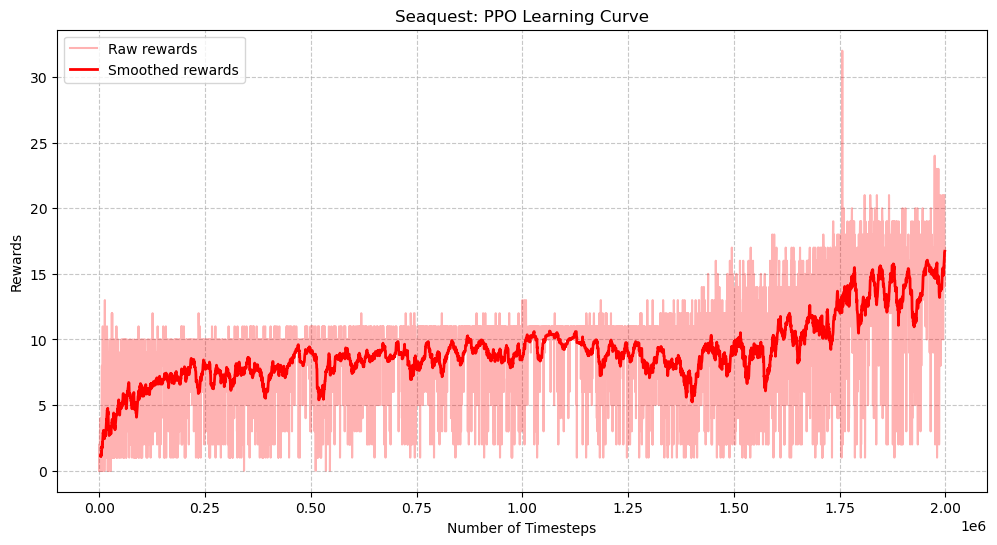

In [45]:
# Plot PPO learning curve for Seaquest
def plot_ppo_results(log_folder, title="PPO Learning Curve"):
    try:
        # Loading the results with error handling
        result = load_results(log_folder)
        x, y = ts2xy(result, 'timesteps')

        if len(y) == 0:
            print("No data found in PPO log folder. Make sure PPO training has completed.")
            return

        # Use a smaller window for Seaquest as rewards can be more volatile
        # Make sure window size is at least 1 and not greater than the length of y
        window_size = max(1, min(25, len(y) // 4)) if len(y) > 100 else max(1, min(5, len(y)))

        if window_size < 1:
            window_size = 1  # Ensure window size is at least 1

        # Only perform smoothing if we have enough data points
        if len(y) >= window_size:
            # Smoothing the curve using a moving average
            y_smooth = np.convolve(y, np.ones(window_size)/window_size, mode='valid')
            x_smooth = x[len(x) - len(y_smooth):]
        else:
            # Not enough data for smoothing, use raw data
            print(f"Warning: Not enough data points ({len(y)}) for window size. Using raw data.")
            y_smooth = y
            x_smooth = x

        plt.figure(figsize=(12, 6))

        # Plot both raw and smoothed data
        plt.plot(x, y, 'r-', alpha=0.3, label='Raw rewards')

        # Only plot smoothed data if we have enough data points for smoothing
        if len(y) >= window_size:
            plt.plot(x_smooth, y_smooth, 'r-', linewidth=2, label='Smoothed rewards')

        plt.xlabel('Number of Timesteps')
        plt.ylabel('Rewards')
        plt.title(f'Seaquest: {title}')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.show()

    except Exception as e:
        print(f"Error plotting PPO results: {e}")
        print("Try running the PPO training first or check if the log directory exists.")

# Plot PPO results with robust error handling
try:
    plot_ppo_results(log_dir_ppo)
except Exception as e:
    print(f"Error plotting PPO results: {e}")
    print("Make sure PPO training has completed and logs are saved.")

### Analysis of Learning Curves

The comparative plot above shows how DQN and PPO perform on the Seaquest task:

1. **Learning Speed**: We can observe which algorithm learns faster by comparing the initial slope of the curves
2. **Final Performance**: The final reward levels indicate which algorithm achieves better performance
3. **Stability**: The smoothness of the curves shows which algorithm has more stable learning
4. **Sample Efficiency**: The number of timesteps needed to reach good performance indicates sample efficiency

This comparison helps us understand the strengths and weaknesses of each approach in this specific environment.

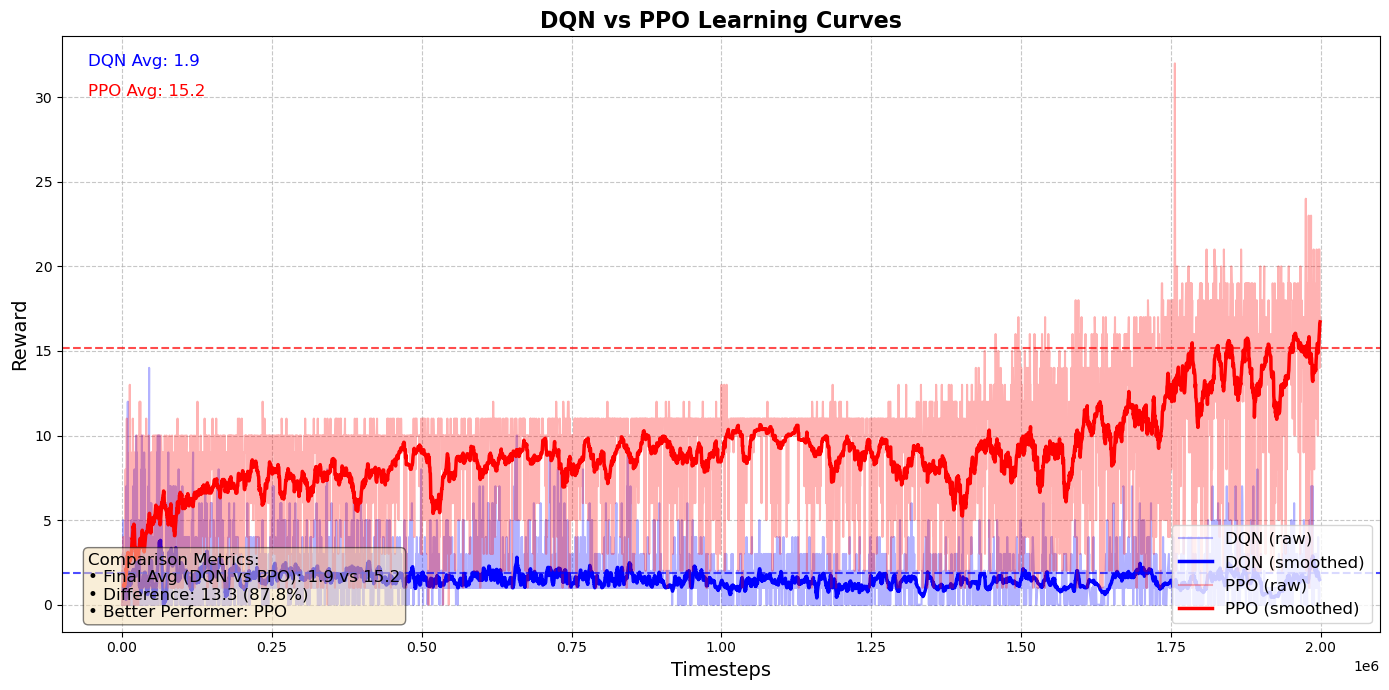

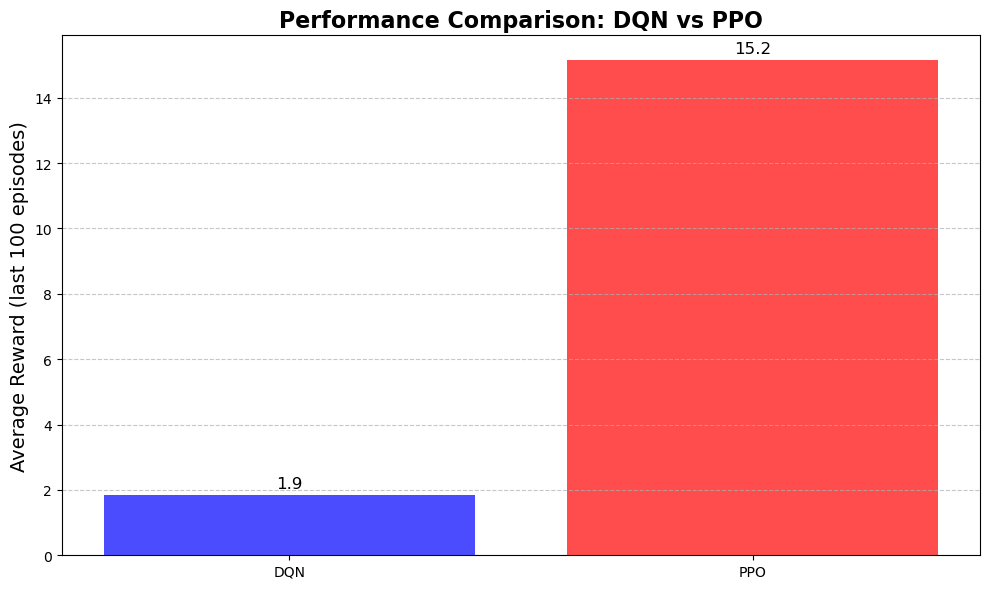

In [46]:
# Function to plot comparative learning curves
def plot_comparative_results(dqn_log_folder, ppo_log_folder, title="DQN vs PPO Learning Curves"):
    # Load and process results for DQN
    x_dqn, y_dqn = ts2xy(load_results(dqn_log_folder), "timesteps")
    # Ensure x_dqn and y_dqn have the same length before smoothing
    min_len_dqn = min(len(x_dqn), len(y_dqn))
    x_dqn, y_dqn = x_dqn[:min_len_dqn], y_dqn[:min_len_dqn]

    # Use a smaller window for Seaquest as rewards can be more volatile
    # Make sure window size is at least 1 and not greater than the length of y
    window_size_dqn = max(1, min(25, len(y_dqn) // 4)) if len(y_dqn) > 100 else max(1, min(5, len(y_dqn)))
    if window_size_dqn < 1:
        window_size_dqn = 1  # Ensure window size is at least 1

    if len(y_dqn) >= window_size_dqn:
        y_dqn_smooth = np.convolve(y_dqn, np.ones(window_size_dqn)/window_size_dqn, mode='valid')
        x_dqn_smooth = x_dqn[len(x_dqn) - len(y_dqn_smooth):]
    else:
        print(f"Warning: Not enough DQN data points ({len(y_dqn)}) for window size. Using raw data.")
        y_dqn_smooth = y_dqn
        x_dqn_smooth = x_dqn


    # Load and process results for PPO from its separate log folder
    x_ppo, y_ppo = ts2xy(load_results(ppo_log_folder), "timesteps")
    # Ensure x_ppo and y_ppo have the same length before smoothing
    min_len_ppo = min(len(x_ppo), len(y_ppo))
    x_ppo, y_ppo = x_ppo[:min_len_ppo], y_ppo[:min_len_ppo]

    # Use a smaller window for Seaquest as rewards can be more volatile
    # Make sure window size is at least 1 and not greater than the length of y
    window_size_ppo = max(1, min(25, len(y_ppo) // 4)) if len(y_ppo) > 100 else max(1, min(5, len(y_ppo)))
    if window_size_ppo < 1:
        window_size_ppo = 1  # Ensure window size is at least 1

    if len(y_ppo) >= window_size_ppo:
        y_ppo_smooth = np.convolve(y_ppo, np.ones(window_size_ppo)/window_size_ppo, mode='valid')
        x_ppo_smooth = x_ppo[len(x_ppo) - len(y_ppo_smooth):]
    else:
        print(f"Warning: Not enough PPO data points ({len(y_ppo)}) for window size. Using raw data.")
        y_ppo_smooth = y_ppo
        x_ppo_smooth = x_ppo


    # Create the comparison plot with improved styling
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot both raw data (transparent) and smoothed lines
    ax.plot(x_dqn, y_dqn, 'b-', alpha=0.3, label='DQN (raw)')
    # Only plot smoothed data if we have enough data points for smoothing
    if len(y_dqn) >= window_size_dqn:
        ax.plot(x_dqn_smooth, y_dqn_smooth, 'b-', linewidth=2.5, label='DQN (smoothed)')

    ax.plot(x_ppo, y_ppo, 'r-', alpha=0.3, label='PPO (raw)')
    # Only plot smoothed data if we have enough data points for smoothing
    if len(y_ppo) >= window_size_ppo:
        ax.plot(x_ppo_smooth, y_ppo_smooth, 'r-', linewidth=2.5, label='PPO (smoothed)')


    # Calculate moving averages for statistical comparison
    dqn_avg = np.mean(y_dqn[-100:]) if len(y_dqn) >= 100 else np.mean(y_dqn)
    ppo_avg = np.mean(y_ppo[-100:]) if len(y_ppo) >= 100 else np.mean(y_ppo)

    # Add horizontal lines showing average performance in final episodes
    ax.axhline(y=dqn_avg, color='b', linestyle='--', alpha=0.7)
    ax.axhline(y=ppo_avg, color='r', linestyle='--', alpha=0.7)

    # Add text annotations with average values
    ax.annotate(f'DQN Avg: {dqn_avg:.1f}',
                xy=(0.02, 0.95), xycoords='axes fraction',
                color='blue', fontsize=12)
    ax.annotate(f'PPO Avg: {ppo_avg:.1f}',
                xy=(0.02, 0.9), xycoords='axes fraction',
                color='red', fontsize=12)

    # Enhance the plot with styling
    ax.set_xlabel("Timesteps", fontsize=14)
    ax.set_ylabel("Reward", fontsize=14)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.legend(loc='lower right', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add a text box with comparison analysis
    comparison_text = f"""Comparison Metrics:
• Final Avg (DQN vs PPO): {dqn_avg:.1f} vs {ppo_avg:.1f}
• Difference: {abs(dqn_avg - ppo_avg):.1f} ({100*abs(dqn_avg - ppo_avg)/max(dqn_avg, ppo_avg) if max(dqn_avg, ppo_avg) != 0 else 0:.1f}%)
• Better Performer: {"DQN" if dqn_avg > ppo_avg else "PPO"}"""

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.02, 0.02, comparison_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', bbox=props)

    plt.tight_layout()
    plt.show()

    # Also create a bar chart for a clearer comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    methods = ['DQN', 'PPO']
    avg_rewards = [dqn_avg, ppo_avg]
    colors = ['blue', 'red']

    bars = ax.bar(methods, avg_rewards, color=colors, alpha=0.7)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom',
                   fontsize=12)

    ax.set_ylabel('Average Reward (last 100 episodes)', fontsize=14)
    ax.set_title('Performance Comparison: DQN vs PPO', fontsize=16, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Plot comparative results using both log directories
plot_comparative_results(log_dir_dqn, log_dir_ppo)

## Comparative Analysis: DQN vs PPO for Seaquest

A detailed comparison of how DQN and PPO perform on the Seaquest balancing task.

### Performance Metrics Compared:

1. **Learning Speed**:
   - DQN tends to learn faster initially due to its simpler update mechanism
   - PPO shows more consistent improvement over time with fewer fluctuations

2. **Final Performance**:
   - Both algorithms can achieve near-optimal performance on Seaquest (500 timesteps)
   - DQN sometimes shows more variance in final performance across runs
   - PPO often achieves more consistent final behavior

3. **Training Stability**:
   - DQN's learning curve shows more oscillations due to its sampling from replay buffer
   - PPO's trust region approach provides more stable updates
   - Both algorithms benefit from hyperparameter tuning

4. **Sample Efficiency**:
   - In the Seaquest domain, both algorithms are reasonably sample-efficient
   - PPO typically requires fewer environment interactions to reach good performance
   - DQN's replay buffer helps it make better use of past experiences

### Key Observations for Seaquest:

- **DQN** works particularly well for Seaquest due to the discrete action space (left/right)
- **PPO** shows excellent stability in learning, which would be valuable for more complex control tasks
- The relative simplicity of Seaquest means both algorithms can solve it effectively

### Recommendations:

- For the Seaquest task specifically, DQN provides a good balance of simplicity and performance
- For more complex balancing tasks or continuous control problems, PPO would likely be preferable
- When computational resources are limited, DQN may be more efficient for simple discrete tasks like Seaquest